# Visulising the backbone

Backbone == showerflow

Going to make a sequence of plots to see the backbone performance compare to the data.

## version 4.6

Currently; fits used in backbone are Weibull (experimental) for n-hits, 1D log normal for mean point energy. The fits used in the layers are a 2D gauss for the lateral shape, and a LogNormal for the distribution of energies within an event.
Fits are now polynomial, 3rd order, with respect to the incident energy.

## Content of notebook

Histograms;
- Total predicted energy
   * Summed over all layers
   * In each layer
- Total predicted hits
   * Summed over all layers
   * In each layer

Scatter plots;

- Incident energy v.s. predicted visible energy
   * Summed over all layers
   * In each layer
- Incident energy v.s. predicted hits
   * Summed over all layers
   * In each layer
- For fixed incident energy
   * Distribution of visible energy
       * Summed over all layers
       * In each layer
   * Distribution of hits
       * Summed over all layers
       * In each layer
       


## Histograms

Start by getting g4 data


In [1]:
from pointcloud.utils.stats_accumulator import StatsAccumulator, HighLevelStats
from pointcloud.models.wish import load_wish_from_accumulator
import numpy as np
from pointcloud.config_varients.wish_maxwell import Configs
from pointcloud.utils.metadata import Metadata
from pointcloud.data.dataset import PointCloudDataset

configs = Configs()
configs.poly_degree = 3
meta = Metadata(configs)

remake_wish = False
redo_wish_data = True
redo_g4_data = True

energy_lower = 0.0 # 0.25
energy_upper = np.inf
varient = ""  # could also use "_0p25", or "_0"
#file_path = f"../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32_filtered/from_10{varient}.h5"
#file_path = f"../../../point-cloud-diffusion-logs/wish/dataset_accumulators/initial_accumulation.h5"
file_path = f"../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-100_accumulator.h5"


accumulated_stats = StatsAccumulator.load(file_path)
# get bins
incident_bins = accumulated_stats.incident_bin_boundaries


# Get g4 data
points = incident_bins[:-1] + 0.5*(incident_bins[1:] - incident_bins[:-1])
non_zero_total_events = np.clip(accumulated_stats.total_events, 1, None)
g4_observed_energies = np.sum(accumulated_stats.energy_hist, axis=(1, 2, 3))/non_zero_total_events
g4_observed_energies = g4_observed_energies[1:-1]
g4_observed_hits = np.sum(accumulated_stats.counts_hist, axis=(1, 2, 3))/non_zero_total_events
g4_observed_hits = g4_observed_hits[1:-1]

## 

Get the model under comparison.

In [3]:

from pointcloud.models.wish import Wish

wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32/wish_from_10.pt"

if remake_wish:
    #wish_model = Wish(configs)
    wish_model = load_wish_from_accumulator(file_path, config=configs)
    wish_model.save(wish_path)

wish_model = Wish.load(wish_path)



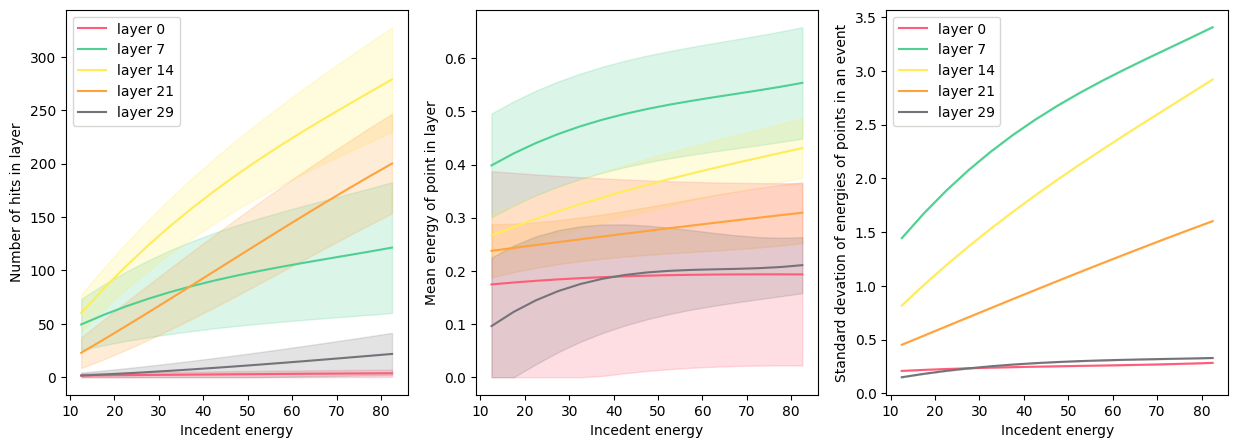

In [4]:
l0 = wish_model.layers[0]
l0.energy_fit.get_standarddev(20)

n_points = len(points)
n_layers = len(wish_model.layers)
from matplotlib import pyplot as plt
from pointcloud.utils.plotting import plot_line_with_devation
import numpy as np
n_intrest = 5
layers_of_intrest = np.linspace(0, n_layers-1, n_intrest).astype(int)

nice_hex = [["#00E5E3", "#8DD7BF", "#FF96C5", "#FF5768", "#FFBF65"],
            ["#FC6238", "#FFD872", "#F2D4CC", "#E77577", "#6C88C4"],
            ["#C05780", "#FF828B", "#E7C582", "#00B0BA", "#0065A2"],
            ["#00CDAC", "#FF6F68", "#FFDACC", "#FF60A8", "#CFF800"],
            ["#FF5C77", "#4DD091", "#FFEC59", "#FFA23A", "#74737A"]]


fig, (ax_hits, ax_meanE, ax_rangeE) = plt.subplots(1,3, figsize=(15, 5))

c_row = 4
for intrest_n, layer_n in enumerate(layers_of_intrest):
    # n hits
    n_hits_fit = wish_model.backbone.n_pts_fits[layer_n]
    mean_n_hits = np.fromiter((n_hits_fit.get_mean(p) for p in points), dtype=float)
    std_n_hits = np.fromiter((n_hits_fit.get_standarddev(p) for p in points), dtype=float)
    plot_line_with_devation(ax_hits, nice_hex[c_row][intrest_n], points, mean_n_hits, std_n_hits, clip_to_zero=True, label=f"layer {layer_n}")

    # event mean point energy
    meanE_fit = wish_model.backbone.energy_fits[layer_n]
    mean_meanE = np.fromiter((meanE_fit.get_mean(p) for p in points), dtype=float)
    std_meanE = np.fromiter((meanE_fit.get_standarddev(p) for p in points), dtype=float)
    plot_line_with_devation(ax_meanE, nice_hex[c_row][intrest_n], points, mean_meanE, std_meanE, clip_to_zero=True, label=f"layer {layer_n}")

    # event varation in point energy
    layer = wish_model.layers[layer_n].energy_fit
    mean_layerE = np.ones(n_points)
    std_layerE = np.fromiter((layer.get_standarddev(p) for p in points), dtype=float)
    plot_line_with_devation(ax_rangeE, nice_hex[c_row][intrest_n], points, std_layerE, 0, clip_to_zero=True, label=f"layer {layer_n}")
    
    
ax_hits.set_xlabel("Incedent energy")
ax_meanE.set_xlabel("Incedent energy")
ax_rangeE.set_xlabel("Incedent energy")
ax_hits.set_ylabel("Number of hits in layer")
ax_meanE.set_ylabel("Mean energy of point in layer")
ax_rangeE.set_ylabel("Standard devation of energies of points in an event")
    
ax_hits.legend()
ax_rangeE.legend()

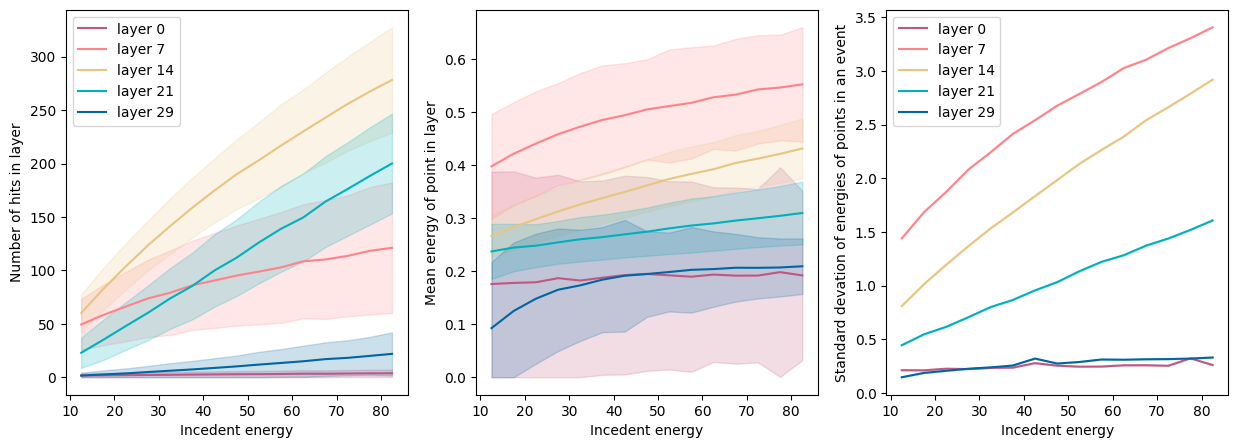

In [5]:

high_level_stats = HighLevelStats(accumulated_stats, configs.poly_degree)
hls_points = high_level_stats.incident_energy_bin_centers

def get_n_pts(layer_n):
    mean = high_level_stats.get_n_pts_vs_incident_energy(layer_n)
    mean_sq = accumulated_stats.evt_counts_sq_hist[1:-1][high_level_stats.event_mask, layer_n]/high_level_stats.total_events_per_incedent_energy
    std = np.sqrt(mean_sq - mean**2)
    return mean, std

def get_meanE(layer_n):
    mean = accumulated_stats.evt_mean_E_hist[1:-1][high_level_stats.event_mask, layer_n]/high_level_stats.total_events_per_incedent_energy
    mean_sq = accumulated_stats.evt_mean_E_sq_hist[1:-1][high_level_stats.event_mask, layer_n]/high_level_stats.total_events_per_incedent_energy
    std = np.sqrt(mean_sq - mean**2)
    return mean, std

def get_rangeE(layer_n):
    mean_sq = accumulated_stats.evt_mean_E_sq_hist[1:-1][high_level_stats.event_mask, layer_n]/high_level_stats.total_events_per_incedent_energy
    mean_pnt_sq = accumulated_stats.pnt_mean_E_sq_hist[1:-1][high_level_stats.event_mask, layer_n]/high_level_stats.total_events_per_incedent_energy
    std = np.sqrt(mean_pnt_sq - mean_sq)
    return std
    
fig, (ax_hits, ax_meanE, ax_rangeE) = plt.subplots(1,3, figsize=(15, 5))

for intrest_n, layer_n in enumerate(layers_of_intrest):
    # n hits
    mean_n_hits, std_n_hits = get_n_pts(layer_n)
    plot_line_with_devation(ax_hits, nice_hex[2][intrest_n], points, mean_n_hits, std_n_hits, clip_to_zero=True, label=f"layer {layer_n}")

    # event mean point energy
    mean_meanE, std_meanE = get_meanE(layer_n)
    plot_line_with_devation(ax_meanE, nice_hex[2][intrest_n], points, mean_meanE, std_meanE, clip_to_zero=True, label=f"layer {layer_n}")

    # event varation in point energy
    std_layerE = get_rangeE(layer_n)
    plot_line_with_devation(ax_rangeE, nice_hex[2][intrest_n], points, std_layerE, 0, clip_to_zero=True, label=f"layer {layer_n}")
    
    
ax_hits.set_xlabel("Incedent energy")
ax_meanE.set_xlabel("Incedent energy")
ax_rangeE.set_xlabel("Incedent energy")
ax_hits.set_ylabel("Number of hits in layer")
ax_meanE.set_ylabel("Mean energy of point in layer")
ax_rangeE.set_ylabel("Standard devation of energies of points in an event")
    
ax_hits.legend()
ax_rangeE.legend()
    

Generate some data from that model.

In [6]:
import torch
torch.manual_seed(0)
from pointcloud.utils.detector_map import split_to_layers

n_tries_per_point = 10
wish_histo_path = f"../../../point-cloud-diffusion-data/wish_histo_data{varient}.h5"

import os, h5py
if os.path.exists(wish_histo_path) and not redo_wish_data:
    opened_wish_histo = h5py.File(wish_histo_path, 'r')
    wish_observed_sum_E_means = opened_wish_histo["wish_observed_sum_E_means"][:]
    wish_observed_sum_E_stds = opened_wish_histo["wish_observed_sum_E_stds"][:]
    wish_observed_layer_E_means = opened_wish_histo["wish_observed_layer_E_means"][:]
    wish_observed_layer_E_stds = opened_wish_histo["wish_observed_layer_E_stds"][:]
    
    wish_observed_sum_hits_means = opened_wish_histo["wish_observed_sum_hits_means"][:]
    wish_observed_sum_hits_stds = opened_wish_histo["wish_observed_sum_hits_stds"][:]
    wish_observed_layer_hits_means = opened_wish_histo["wish_observed_layer_hits_means"][:]
    wish_observed_layer_hits_stds = opened_wish_histo["wish_observed_layer_hits_stds"][:]
else:

    wish_observed_sum_E_means = np.empty(n_points)
    wish_observed_sum_E_stds = np.empty(n_points)
    wish_observed_layer_E_means = np.empty((n_points, n_layers))
    wish_observed_layer_E_stds = np.empty((n_points, n_layers))

    wish_observed_sum_hits_means = np.empty(n_points)
    wish_observed_sum_hits_stds = np.empty(n_points)
    wish_observed_layer_hits_means = np.empty((n_points, n_layers))
    wish_observed_layer_hits_stds = np.empty((n_points, n_layers))

    layer_bottom_pos = np.linspace(0, 29, 30)

    for i, incident in enumerate(points):
        energies_per_layer = []
        energies_total = []
        hits_per_layer = []
        hits_total = []
        for _ in range(n_tries_per_point):
            xs, ys, zs, es = wish_model.inference(incident)
            energies_total.append(np.sum(es))
            hits_total.append(len(es))
            all_layers = np.vstack((xs, ys, zs, es)).T
            layer_energies = []
            layer_hits = []
            for layer in split_to_layers(all_layers, layer_bottom_pos, 0.5):
                layer_energies.append(np.sum(layer[:, 3]))
                layer_hits.append(len(layer))
            energies_per_layer.append(layer_energies)
            hits_per_layer.append(layer_hits)
        wish_observed_sum_E_means[i] = np.mean(energies_total)
        wish_observed_sum_E_stds[i] = np.std(energies_total)
        wish_observed_sum_hits_means[i] = np.mean(hits_total)
        wish_observed_sum_hits_stds[i] = np.std(hits_total)
        for layer_n in range(n_layers):
            layer_energies = [e[layer_n] for e in energies_per_layer]
            wish_observed_layer_E_means[i, layer_n] = np.mean(layer_energies)
            wish_observed_layer_E_stds[i, layer_n] = np.std(layer_energies)
            layer_hits = [h[layer_n] for h in hits_per_layer]
            wish_observed_layer_hits_means[i, layer_n] = np.mean(layer_hits)
            wish_observed_layer_hits_stds[i, layer_n] = np.std(layer_hits)
        print(f"{i/n_points:.0%}", end='\r')

    # save for next time
    opened_wish_histo = h5py.File(wish_histo_path, 'w')
    opened_wish_histo.create_dataset("wish_observed_sum_E_means", data=wish_observed_sum_E_means)
    opened_wish_histo.create_dataset("wish_observed_sum_E_stds", data=wish_observed_sum_E_stds)
    opened_wish_histo.create_dataset("wish_observed_layer_E_means", data=wish_observed_layer_E_means)
    opened_wish_histo.create_dataset("wish_observed_layer_E_stds", data=wish_observed_layer_E_stds)
    opened_wish_histo.create_dataset("wish_observed_sum_hits_means", data=wish_observed_sum_hits_means)
    opened_wish_histo.create_dataset("wish_observed_sum_hits_stds", data=wish_observed_sum_hits_stds)
    opened_wish_histo.create_dataset("wish_observed_layer_hits_means", data=wish_observed_layer_hits_means)
    opened_wish_histo.create_dataset("wish_observed_layer_hits_stds", data=wish_observed_layer_hits_stds)
    opened_wish_histo.close()
        

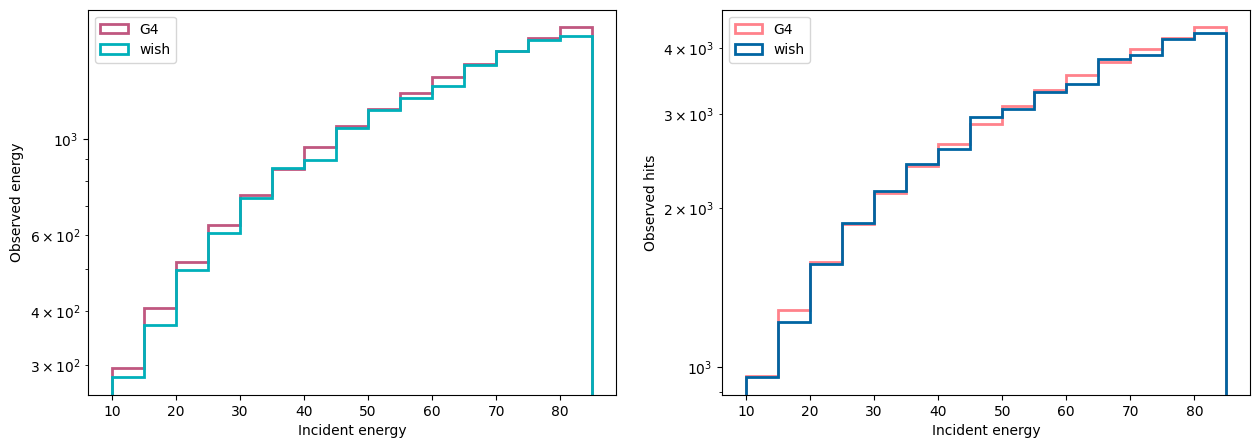

In [7]:
import numpy as np
fig, (ax_e, ax_hit) = plt.subplots(1, 2, figsize=(15, 5))

#energy
ax_e.semilogy()

global_hist_params = dict(bins=incident_bins, histtype="step", lw=2)

g4_hist_params1 = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
ax_e.hist(points, weights=g4_observed_energies, **g4_hist_params1)
wish_hist_params1 = dict(label="wish", color=nice_hex[2][3], **global_hist_params)
ax_e.hist(points, weights=wish_observed_sum_E_means, **wish_hist_params1)

ax_e.set_xlabel("Incident energy")
ax_e.set_ylabel("Observed energy")
ax_e.legend()

#hits
ax_hit.semilogy()

g4_hist_params2 = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
ax_hit.hist(points, weights=g4_observed_hits, **g4_hist_params2)
wish_hist_params2 = dict(label="wish", color=nice_hex[2][4], **global_hist_params)
ax_hit.hist(points, weights=wish_observed_sum_hits_means, **wish_hist_params2)

ax_hit.set_xlabel("Incident energy")
ax_hit.set_ylabel("Observed hits")
ax_hit.legend()

Note that what is being compared here is wish to the accumulated stats. It would show issues in the converstion from stats to model.

Also, look at then energies in some layers;

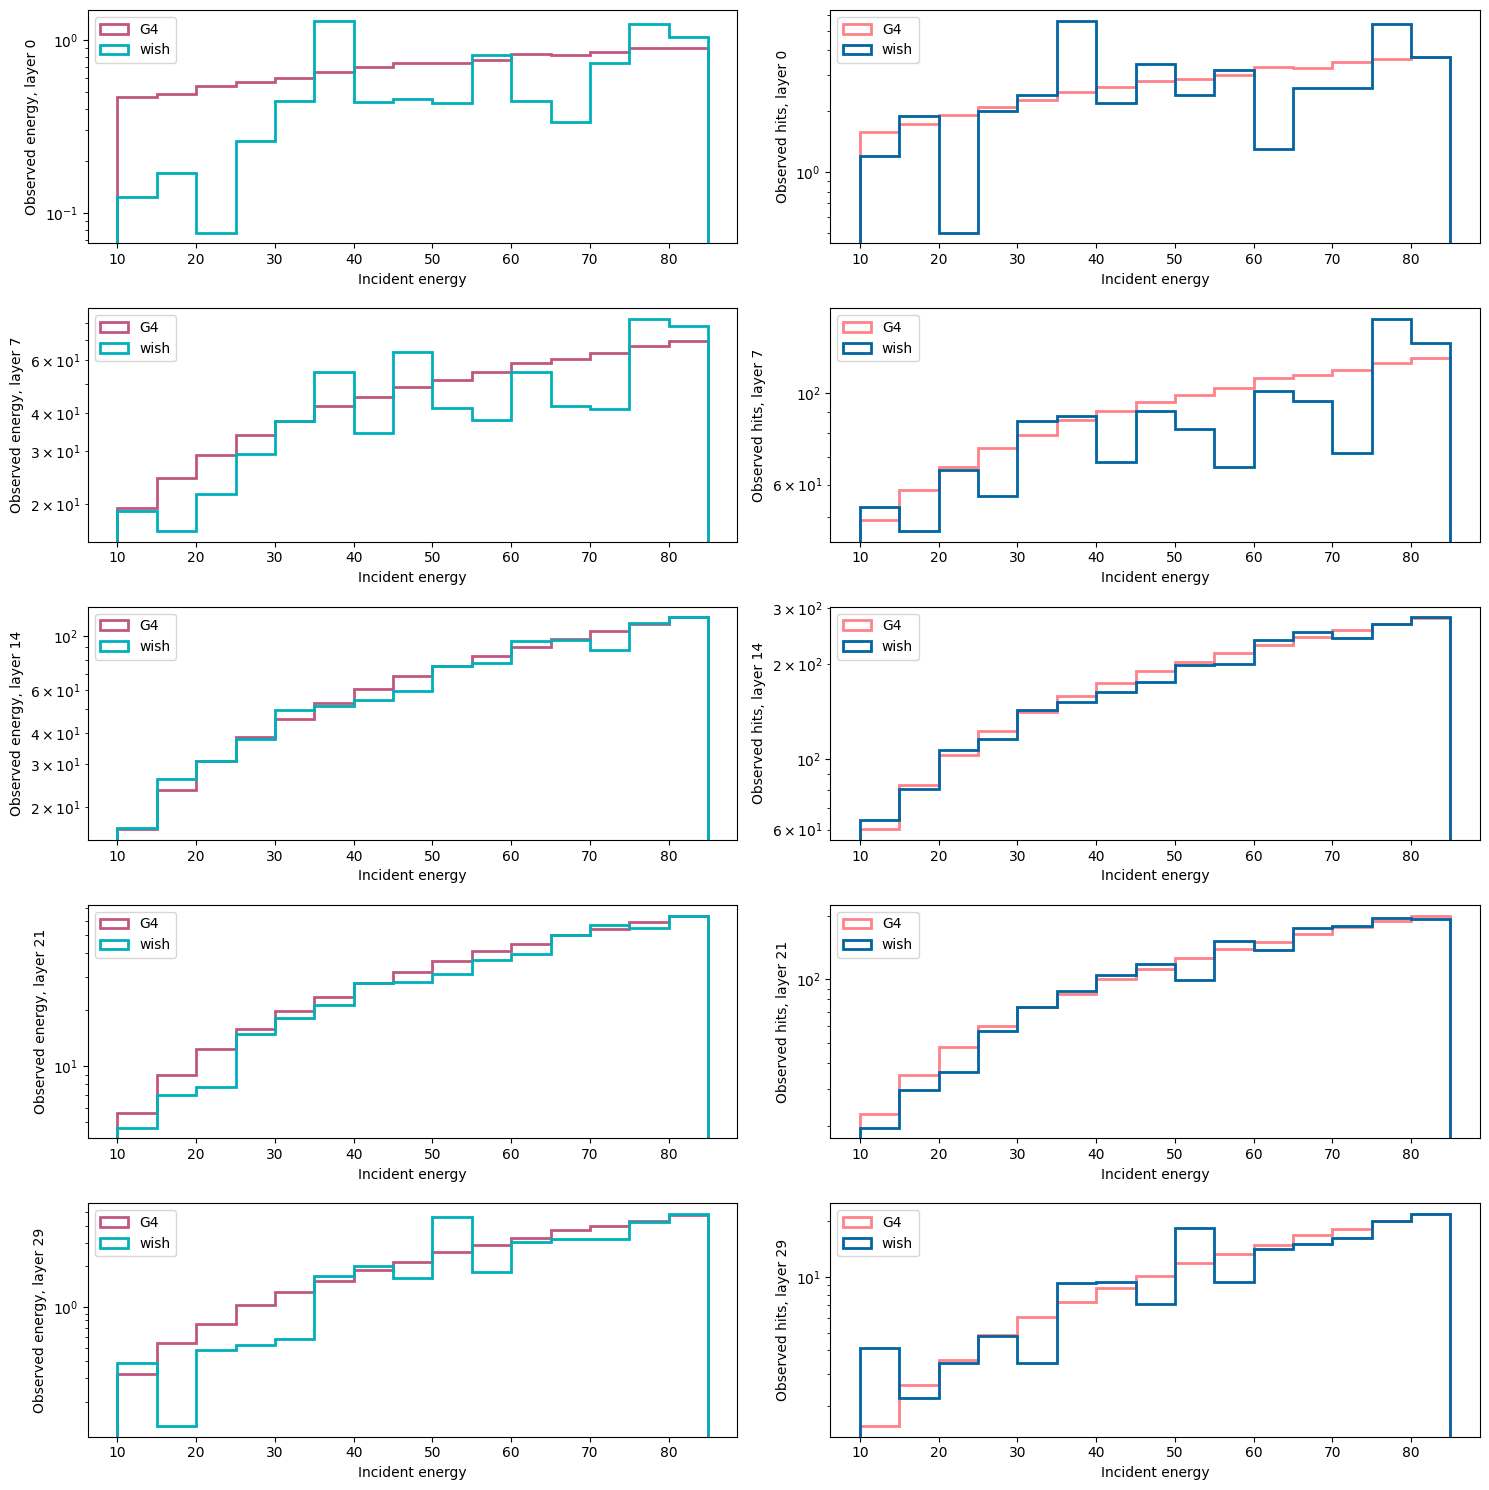

In [8]:
fig, axes = plt.subplots(n_intrest, 2, figsize=(15, 3*n_intrest))

for ax_n, layer_n in enumerate(layers_of_intrest):
    # get the g4 data
    g4_observed_energies_layer = np.sum(accumulated_stats.energy_hist[:, layer_n], axis=(1, 2))/non_zero_total_events
    g4_observed_energies_layer = g4_observed_energies_layer[1:-1]
    g4_observed_hits_layer = np.sum(accumulated_stats.counts_hist[:, layer_n], axis=(1, 2))/non_zero_total_events
    g4_observed_hits_layer = g4_observed_hits_layer[1:-1]
    #energy
    ax_e = axes[ax_n, 0]
    ax_e.semilogy()
    
    ax_e.hist(points, weights=g4_observed_energies_layer, **g4_hist_params1)
    ax_e.hist(points, weights=wish_observed_layer_E_means[:, layer_n], **wish_hist_params1)

    ax_e.set_xlabel("Incident energy")
    ax_e.set_ylabel(f"Observed energy, layer {layer_n}")
    ax_e.legend()

    #hits
    ax_hit = axes[ax_n, 1]
    ax_hit.semilogy()

    ax_hit.hist(points, weights=g4_observed_hits_layer, **g4_hist_params2)
    ax_hit.hist(points, weights=wish_observed_layer_hits_means[:, layer_n], **wish_hist_params2)

    ax_hit.set_xlabel("Incident energy")
    ax_hit.set_ylabel(f"Observed hits, layer {layer_n}")
    ax_hit.legend()
fig.tight_layout()

### Evaluation of Histograms


There is a normalisation issue in the observed energy.
It's not that good, layer 7 looks too low everywhere for example.
It's not disastrous either though.

## Scatter plots

Start by getting some g4 data

In [9]:

import h5py
file_path = "../../../point-cloud-diffusion-data/even_batch_10k.h5"
opened_g4 = h5py.File(file_path)
g4_events = opened_g4['event'][0]
incidents = np.squeeze(opened_g4['energy'])
n_events, max_points, _ = g4_events.shape

Generate some equivalent data from the model


In [10]:
wish_file_path = f"../../../point-cloud-diffusion-data/even_batch_10k_wish{varient}.h5"

if os.path.exists(wish_file_path) and not redo_wish_data:
    opened_wish = h5py.File(wish_file_path, 'r')
    wish_events = opened_wish["event"][:]
else:
    wish_events = np.zeros_like(g4_events)
    n_events = g4_events.shape[0]
    max_points = g4_events.shape[1]
    for i, incident in enumerate(incidents):
        if i % 100 == 0:
            print(f"{i/n_events:.0%}", end="\r")
        xs, ys, zs, es = wish_model.inference(incident)
        n_pts = len(xs)
        wish_events[i, :n_pts, 0] = xs[:max_points]
        wish_events[i, :n_pts, 1] = ys[:max_points]
        wish_events[i, :n_pts, 2] = zs[:max_points]
        wish_events[i, :n_pts, 3] = es[:max_points]
    # Save that
    opened_wish = h5py.File(wish_file_path, 'w')
    opened_wish.create_dataset("event", data=wish_events)
    opened_wish.create_dataset("energy", data=incidents)
    opened_wish.close()

Now scatters like the things that where histogrammed above.

In [18]:
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

sum_data = {"incident energy": incidents}

#energy
g4_energies = g4_events[:, :, 3]
g4_energies[g4_energies<energy_lower] = 0.
g4_energies[g4_energies>energy_upper] = 0.

sum_data["g4 energy"] = np.sum(g4_energies[:, :], axis=1)
sum_data["wish energy"] = np.sum(wish_events[:, :, 3], axis=1)

# hits
sum_data["g4 hits"] = np.sum(g4_energies[:, :]>0, axis=1)
sum_data["wish hits"] = np.sum(wish_events[:, :, 3]>0, axis=1)

sum_dataframe = pd.DataFrame(data=sum_data)

fig = make_subplots(rows=2, cols=2) 
g_sub_fig_e = px.scatter(sum_dataframe, x="incident energy", y=["g4 energy"],
                       opacity=0.5,
                       color_discrete_sequence=[nice_hex[2][0], nice_hex[2][3]])
g_sub_fig_hits = px.scatter(sum_dataframe, x="incident energy", y=["g4 hits"],
                          opacity=0.5,
                          color_discrete_sequence=[nice_hex[2][1], nice_hex[2][4]])
sub_fig_e = px.scatter(sum_dataframe, x="incident energy", y=["g4 energy", "wish energy"],
                       opacity=0.5,
                       color_discrete_sequence=[nice_hex[2][0], nice_hex[2][3]])
sub_fig_hits = px.scatter(sum_dataframe, x="incident energy", y=["g4 hits", "wish hits"],
                          opacity=0.5,
                          color_discrete_sequence=[nice_hex[2][1], nice_hex[2][4]])
# add each trace (or traces) to its specific subplot
for i in g_sub_fig_e.data :
    fig.add_trace(i, row=1, col=1)

for i in g_sub_fig_hits.data :    
    fig.add_trace(i, row=1, col=2)
    
for i in sub_fig_e.data :
    fig.add_trace(i, row=2, col=1)

for i in sub_fig_hits.data :    
    fig.add_trace(i, row=2, col=2)
fig['layout']['xaxis']['title']='Incident energy'
fig['layout']['yaxis']['title']='Observed energy'
fig['layout']['xaxis2']['title']='Incident energy'
fig['layout']['yaxis2']['title']='Observed hits'

In [19]:
import plotly.io as pio
pio.renderers.default = 'iframe'

fig.show()

Now to get the energy per layer, it's going to be easiest to define a completely new dataset.

In [13]:
g4_energy_per_layer = {f"layer {layer_n}, g4 energy": np.empty(n_events) for layer_n in range(n_layers)}
g4_hits_per_layer = {f"layer {layer_n}, g4 hits": np.empty(n_events) for layer_n in range(n_layers)}

print("Processing g4")
layer_bottom_pos = np.linspace(-1, 1, n_layers)
cell_thickness = layer_bottom_pos[1] - layer_bottom_pos[0]
for event_n, event in enumerate(g4_events):
    for layer_n, layer in enumerate(split_to_layers(event, layer_bottom_pos, cell_thickness)):
        mask = (layer[:, 3] > energy_lower) * (layer[:, 3] < energy_upper)
        g4_energy_per_layer[f"layer {layer_n}, g4 energy"][event_n] = np.sum(layer[mask, 3])
        g4_hits_per_layer[f"layer {layer_n}, g4 hits"][event_n] = np.sum(mask)


wish_energy_per_layer = {f"layer {layer_n}, wish energy": np.empty(n_events) for layer_n in range(n_layers)}
wish_hits_per_layer = {f"layer {layer_n}, wish hits": np.empty(n_events) for layer_n in range(n_layers)}

print("Processing wish")
layer_bottom_pos = np.linspace(0, 29, n_layers)
cell_thickness = layer_bottom_pos[1] - layer_bottom_pos[0]
for event_n, event in enumerate(wish_events):
    for layer_n, layer in enumerate(split_to_layers(event, layer_bottom_pos, cell_thickness)):
        mask = layer[:, 3] > 0
        wish_energy_per_layer[f"layer {layer_n}, wish energy"][event_n] = np.sum(layer[mask, 3])
        wish_hits_per_layer[f"layer {layer_n}, wish hits"][event_n] = np.sum(mask)

all_data = {"incident energy": incidents}
all_data.update(g4_energy_per_layer)
all_data.update(g4_hits_per_layer)
all_data.update(wish_energy_per_layer)
all_data.update(wish_hits_per_layer)

per_layer = pd.DataFrame(data=all_data)



Processing g4
Processing wish


### Layer by layer comparisons.

Now the same thing, but split by layers.

In [14]:

layer_fig = make_subplots(rows=len(layers_of_intrest), cols=2) 

for ax_n, layer_n in enumerate(layers_of_intrest):
    y_ax_e = [f"layer {layer_n}, g4 energy", f"layer {layer_n}, wish energy"]
    sub_fig_e = px.scatter(per_layer, x="incident energy", y=y_ax_e,
                           opacity=0.5,
                           color_discrete_sequence=[nice_hex[ax_n][0], nice_hex[ax_n][3]])
    y_ax_hits = [f"layer {layer_n}, g4 hits", f"layer {layer_n}, wish hits"]
    sub_fig_hits = px.scatter(per_layer, x="incident energy", y=y_ax_hits,
                              opacity=0.5,
                              color_discrete_sequence=[nice_hex[ax_n][1], nice_hex[ax_n][4]])
    # add each trace (or traces) to its specific subplot
    for i in sub_fig_e.data :
        layer_fig.add_trace(i, row=ax_n+1, col=1)
    
    for i in sub_fig_hits.data :    
        layer_fig.add_trace(i, row=ax_n+1, col=2)
    e_ax_num = (ax_n)*2 + 1
    e_ax_num = (ax_n)*2 + 1
    layer_fig['layout'][f'xaxis{e_ax_num}']['title'] = "Incident energy"
    layer_fig['layout'][f'yaxis{e_ax_num}']['title'] = "Observed energy"
    hit_ax_num = e_ax_num + 1
    layer_fig['layout'][f'xaxis{hit_ax_num}']['title'] = "Incident energy"
    layer_fig['layout'][f'yaxis{hit_ax_num}']['title'] = "Observed hits"


In [15]:
import plotly.io as pio
pio.renderers.default = 'iframe'
layer_fig.update_layout(
    autosize=False,
    width=800,
    height=1200,
)


layer_fig.show()

### Conclusions

The energy is further off than the hits. Some layers are worse than others.


## Fixed energy slices

Now we will sample and make fixed energy slices of data. We will save the produced files to speed up re-running. Start by defining the boundaries of each slice.

In this part, we won't bother to split g4 into energy boundaries.

In [16]:
incident_min = 10
incident_max = 90
n_energy_slices = 5
energy_slice_width = 1
slice_lower_bounds = np.linspace(incident_min, incident_max-energy_slice_width, n_energy_slices).astype(int)
max_showers_in_slice = 5000

In [17]:
g4_slice_paths = "../../../point-cloud-diffusion-data/energy_slices/g4_energy_slice_{}.h5"
try:
    os.mkdir(os.path.dirname(g4_slice_paths))
except FileExistsError:
    pass
from pointcloud.data.read_write import read_raw_regaxes
configs.storage_base = "/mnt/beegfs/desy/user/"
import os, h5py
g4_slice_incidents = []
g4_slice_showers = []
for lower in slice_lower_bounds:
    this_slice_path = g4_slice_paths.format(lower)
    if os.path.exists(this_slice_path) and not redo_g4_data:
        with h5py.File(this_slice_path, 'r') as opened_slice:
            g4_slice_incidents.append(opened_slice['energy'][:])
            g4_slice_showers.append(opened_slice['events'][:])
        
    else:
        print(f"Skimming data for slice {lower}")
        data_path = configs.dataset_path
        with h5py.File(data_path, 'r') as opened_data:
            all_incidents = opened_data['energy']
            upper = lower + energy_slice_width
            good_idxs = np.where(np.squeeze((all_incidents>lower) & (all_incidents<upper)))[0]
            print(f"found {len(good_idxs)} points for slice, will trim to {max_showers_in_slice}")
            good_idxs = np.random.choice(good_idxs, max_showers_in_slice, False)
            good_idxs.sort()
            incidents_here, showers_here = read_raw_regaxes(configs, good_idxs)
            g4_slice_incidents.append(incidents_here)
            g4_slice_showers.append(showers_here)
        with h5py.File(this_slice_path, 'w') as opened_slice:
            opened_slice.create_dataset("energy", data=incidents_here)
            opened_slice.create_dataset("events", data=showers_here)
            
            
        
                  

Skimming data for slice 10


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/beegfs/desy/user/dayhallh/data/ILCsoftEvents/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed{}_all_steps.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Now we need to generate the slices from wish. This is simpler.

In [ ]:
wish_slice_paths = "../../../point-cloud-diffusion-data/energy_slices/wish_energy_slice_{}" + varient + ".h5"
try:
    os.mkdir(os.path.dirname(wish_slice_paths))
except FileExistsError:
    pass

import os, h5py
wish_slice_incidents = []
wish_slice_showers = []
for slice_n, lower in enumerate(slice_lower_bounds):
    this_slice_path = wish_slice_paths.format(lower)
    if os.path.exists(this_slice_path) and not redo_wish_data:
        with h5py.File(this_slice_path, 'r') as opened_slice:
            wish_slice_incidents.append(opened_slice['energy'][:])
            wish_slice_showers.append(opened_slice['events'][:])
        
    else:
        print(f"Generating data for slice {lower}")
        #incidents_here = np.linspace(lower, lower+energy_slice_width, max_showers_in_slice)
        incidents_here = g4_slice_incidents[slice_n]
        showers_here = np.zeros((max_showers_in_slice, max_points, 4))
        for shower_n, incident_e in enumerate(incidents_here):
            xs, ys, zs, es = wish_model.inference(incident_e)
            n_pts = len(xs)
            showers_here[shower_n, :n_pts, 0] = xs[:max_points]
            showers_here[shower_n, :n_pts, 1] = ys[:max_points]
            showers_here[shower_n, :n_pts, 2] = zs[:max_points]
            showers_here[shower_n, :n_pts, 3] = es[:max_points]
        wish_slice_incidents.append(incidents_here)
        wish_slice_showers.append(showers_here)
        with h5py.File(this_slice_path, 'w') as opened_slice:
            opened_slice.create_dataset("energy", data=incidents_here)
            opened_slice.create_dataset("events", data=showers_here)
            
            
        

## Plotting energy slices
We break this down by both energy slice, and layer number. This gives us a grid, with each column repereseting energy slice, and each row reperesenting a layer number. A busy plot, as such the histograms for n_hits will be shown first, then the histograms for observed energy. 

In [ ]:
g4_slices_nhits = np.empty((len(layers_of_intrest), n_energy_slices, max_showers_in_slice))
g4_slices_mean_energy = np.zeros_like(g4_slices_nhits)
g4_slices_point_energy = [[[] for _ in range(n_energy_slices)] for _ in layers_of_intrest]

g4_up_slices_nhits = np.empty((len(layers_of_intrest), n_energy_slices, max_showers_in_slice))
g4_up_slices_mean_energy = np.zeros_like(g4_slices_nhits)
g4_up_slices_point_energy = [[[] for _ in range(n_energy_slices)] for _ in layers_of_intrest]

g4_down_slices_nhits = np.empty((len(layers_of_intrest), n_energy_slices, max_showers_in_slice))
g4_down_slices_mean_energy = np.zeros_like(g4_slices_nhits)
g4_down_slices_point_energy = [[[] for _ in range(n_energy_slices)] for _ in layers_of_intrest]
cut = 0.00006

print("Processing g4")
layer_bottom_pos = np.linspace(0, 29, n_layers)
cell_thickness = layer_bottom_pos[1] - layer_bottom_pos[0]
for energy_slice_n in range(n_energy_slices):
    for event_n, event in enumerate(g4_slice_showers[energy_slice_n]):
        intrest_reached = 0
        for layer_n, layer in enumerate(split_to_layers(event, layer_bottom_pos, cell_thickness)):
            if layer_n not in layers_of_intrest:
                continue
            mask = layer[:, 3] > 0 
            
            g4_slices_nhits[intrest_reached][energy_slice_n][event_n] = np.sum(mask)
            
            up_mask = layer[:, 3] > cut
            down_mask = (layer[:, 3] > 0) * (layer[:, 3] < cut) 

            
            g4_up_slices_nhits[intrest_reached][energy_slice_n][event_n] = np.sum(up_mask)
            g4_down_slices_nhits[intrest_reached][energy_slice_n][event_n] = np.sum(down_mask)
            
            if np.any(mask):
                energy_in_layer = layer[mask, 3]*PointCloudDataset.energy_scale
                g4_slices_mean_energy[intrest_reached][energy_slice_n][event_n] = np.mean(energy_in_layer)
                g4_slices_point_energy[intrest_reached][energy_slice_n] += energy_in_layer.tolist()
                
                up_energy_in_layer = layer[up_mask, 3]*PointCloudDataset.energy_scale
                g4_up_slices_mean_energy[intrest_reached][energy_slice_n][event_n] = np.mean(up_energy_in_layer)
                g4_up_slices_point_energy[intrest_reached][energy_slice_n] += up_energy_in_layer.tolist()
                down_energy_in_layer = layer[down_mask, 3]*PointCloudDataset.energy_scale
                g4_down_slices_mean_energy[intrest_reached][energy_slice_n][event_n] = np.mean(down_energy_in_layer)
                g4_down_slices_point_energy[intrest_reached][energy_slice_n] += down_energy_in_layer.tolist()
                
            intrest_reached += 1




In [ ]:
wish_slices_nhits = np.empty((len(layers_of_intrest), n_energy_slices, max_showers_in_slice))
wish_slices_mean_energy = np.zeros_like(wish_slices_nhits)
wish_slices_point_energy = [[[] for _ in range(n_energy_slices)] for _ in layers_of_intrest]

print("Processing wish")
layer_bottom_pos = np.linspace(0, 29, n_layers)-0.01
cell_thickness = layer_bottom_pos[1] - layer_bottom_pos[0]
for energy_slice_n in range(n_energy_slices):
    for event_n, event in enumerate(wish_slice_showers[energy_slice_n]):
        intrest_reached = 0
        for layer_n, layer in enumerate(split_to_layers(event, layer_bottom_pos, cell_thickness)):
            if layer_n not in layers_of_intrest:
                continue
            mask = layer[:, 3] > 0
            wish_slices_nhits[intrest_reached][energy_slice_n][event_n] = np.sum(mask)
            if np.any(mask):
                wish_slices_mean_energy[intrest_reached][energy_slice_n][event_n] = np.mean(layer[mask, 3])
                wish_slices_point_energy[intrest_reached][energy_slice_n] += (layer[mask, 3]).tolist()
            intrest_reached += 1





In [ ]:
fig_hits, axarr_hits = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))
high_level_stats = HighLevelStats(accumulated_stats, configs.poly_degree)

# which dimensions should be logs?
log_x = False
log_y = False


max_hits = int(max(g4_slices_nhits.max(), wish_slices_nhits.max()))
if log_x:
    bins = np.logspace(np.log10(1.), np.log10(max_hits), 50)
else:
    bins = np.linspace(0, 1000, min(50, max_hits))
global_hist_params = dict(bins=bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][3], **global_hist_params)
up_g4_hist_params = dict(label="up g4", color=nice_hex[3][0], **global_hist_params)
down_g4_hist_params = dict(label="down g4", color=nice_hex[3][3], **global_hist_params)

from scipy.stats import lognorm
stats_params = dict(lw=2, c="black", label="High level stats", alpha=0.5)
stats_params2 = dict(lw=2, c="green", label="Raw stats", alpha=0.8)

for energy_slice_n in range(n_energy_slices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_hits[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {slice_lower_bounds[energy_slice_n]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("N hits")
        if energy_slice_n == 0:
            ax.set_ylabel(f"Layer {layer_n}")
        mean_g4 = np.mean(g4_slices_nhits[intrest_n, energy_slice_n])
        ax.hist(wish_slices_nhits[intrest_n, energy_slice_n], **wish_hist_params)
        ax.hist(g4_slices_nhits[intrest_n, energy_slice_n], **g4_hist_params)
        #ax.hist(g4_down_slices_nhits[intrest_n, energy_slice_n], **down_g4_hist_params)
        #ax.hist(g4_up_slices_nhits[intrest_n, energy_slice_n], **up_g4_hist_params)
        if log_x:
            ax.semilogx()
        if log_y:
            ax.semilogy()
            
        # calculate theory from stats and add
        grad, intercept = high_level_stats.n_pts(layer_n)[:2]
        slice_energy = slice_lower_bounds[energy_slice_n] + 0.5*energy_slice_width
        mu = grad*slice_energy + intercept
        #ax.vlines(mu, 0, 1, color="")
        
        #pmf = lognorm.pmf(k=bins.astype(int), mu=mu)
        #ax.plot(bins, pmf, **stats_params)

        # look at the "raw" stats
        incident_in_hls = high_level_stats.incident_energy_bin_centers
        closest_bin = np.argmin(np.abs(incident_in_hls-slice_energy))
        mu = high_level_stats.get_n_pts_vs_incident_energy(layer_n)[closest_bin]
        #ax.vlines(mu, 0, 1, color="red")
        #ax.vlines(mean_g4, 0, 1, color="green")
        #pmf = poisson.pmf(k=bins.astype(int), mu=mu)
        #ax.plot(bins, pmf, **stats_params2)

        if log_y:
            ax.set_ylim(8e-5, 0.16)
        else:
            ax.set_ylim(0, 0.015)

axarr_hits[0][-1].legend()
plt.tight_layout()
        

In [ ]:
# define a doodled pdf function
from torch.distributions import LogNormal
# to get the scale and the loc from a mean and a std
from pointcloud.models.wish import PolyFit1DLogNormal

def doodle_pdf(bins, energy_slice_n, layer_n, intercept_scale, grad_scale, intercept_shift, grad_shift):
    y0 = 10
    x0 = 0.001
    y1 = 1
    x1 = 0.01
    m = np.log(y1/y0)/np.log(x1/x0)
    b = y0/x0**m
    process_1_pdf = b*(bins**m)
    
    slice_energy = slice_lower_bounds[energy_slice_n] + 0.5*energy_slice_width
    mean_energy_coeffs = high_level_stats.event_mean_point_energy(layer_n)
    mean_energy_coeffs[-1] *= intercept_scale
    mean_energy_coeffs[-2] *= grad_scale
    mean_energy_coeffs[-1] += intercept_shift
    mean_energy_coeffs[-2] += grad_shift
    stdmean_energy_coeffs = high_level_stats.stddev_event_mean_point_energy(layer_n)
    linearFit = PolyFit1DLogNormal(torch.from_numpy(mean_energy_coeffs), torch.from_numpy(stdmean_energy_coeffs))
    positions = torch.Tensor(bins)
    process_2_pdf = np.exp(linearFit.calculate_log_probability(slice_energy, positions).numpy())

    return process_1_pdf, process_2_pdf


In [ ]:
high_level_stats = HighLevelStats(accumulated_stats, configs.poly_degree)

max_means = max(np.nanmax(g4_slices_mean_energy), np.nanmax(wish_slices_mean_energy))

log_x = False
log_y = True
for log_x in [True, False]:
    fig_means, axarr_means = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))
    if log_x:
        bins = np.logspace(np.log10(0.001), np.log10(max_means), 50)
    else:
        #bins = np.linspace(0, max_means, 50)
        bins = np.linspace(0.001, 1, 50)
        #bins = np.linspace(0, 0.2, 50)
    global_hist_params = dict(bins=bins, histtype="step", lw=2, density=True)
    g4_hist_params = dict(label="G4", color=nice_hex[3][0], **global_hist_params)
    up_g4_hist_params = dict(label="up G4", color=nice_hex[1][0], **global_hist_params)
    down_g4_hist_params = dict(label="down G4", color=nice_hex[4][3], **global_hist_params)
    wish_hist_params = dict(label="wish", color=nice_hex[3][3], **global_hist_params)
    
    #from scipy.stats import ??
    stats_params = dict(lw=2, c="black", label="High level stats", alpha=0.5)
    stats_params2 = dict(lw=2, c="green", label="Raw stats", alpha=0.8)
    
    for energy_slice_n in range(n_energy_slices):
        for intrest_n, layer_n in enumerate(layers_of_intrest):
            ax = axarr_means[intrest_n][energy_slice_n]
            if intrest_n == 0:
                ax.set_title(f"Incident {slice_lower_bounds[energy_slice_n]}")
            if intrest_n == len(layers_of_intrest) -1:
                ax.set_xlabel("Mean event energy")
            if energy_slice_n == 0:
                ax.set_ylabel(f"Layer {layer_n}")
            ax.hist(wish_slices_mean_energy[intrest_n, energy_slice_n], **wish_hist_params)
            ax.hist(g4_slices_mean_energy[intrest_n, energy_slice_n], **g4_hist_params)
            #ax.hist(g4_down_slices_mean_energy[intrest_n, energy_slice_n], **down_g4_hist_params)
            #ax.hist(g4_up_slices_mean_energy[intrest_n, energy_slice_n], **up_g4_hist_params)
            if log_y:
                ax.semilogy()
            if log_x:
                ax.semilogx()
                
    
            # doodle another fit
            #process_1_pdf, process_2_pdf = doodle_pdf(bins, energy_slice_n, layer_n, 1., 0.5, 0.1, 0.)
        
            #ax.plot(bins, process_1_pdf, c="orange", linestyle='--')
            #ax.plot(bins, process_1_pdf + process_2_pdf, c="orange", linestyle='-.')
            if not log_y:
                ax.set_ylim(0., 20)
            else:
                ax.set_ylim(8e-2, 100.)
    
    axarr_means[0][-1].legend()
    plt.tight_layout()
            

In [ ]:
fig_energy, axarr_energy = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))

max_energy = max(np.max([np.max([np.max(ps) for ps in layer]) for layer in g4_slices_point_energy]),
                 np.max([np.max([np.max(ps) for ps in layer]) for layer in wish_slices_point_energy]))

log_x = False
log_y = True

if log_x:
    bins = np.logspace(np.log10(1.), np.log10(75), 50)
else:
    bins = np.linspace(0, 10., 35)

global_hist_params = dict(bins=bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
up_g4_hist_params = dict(label="up G4", color=nice_hex[0][1], **global_hist_params)
down_g4_hist_params = dict(label="down G4", color=nice_hex[0][3], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][4], **global_hist_params)

from scipy.stats import norm

for energy_slice_n in range(n_energy_slices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_energy[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {slice_lower_bounds[energy_slice_n]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("Energy of hits")
        if energy_slice_n == 0:
            ax.set_ylabel(f"Layer {layer_n}")
        ax.hist(wish_slices_point_energy[intrest_n][energy_slice_n], **wish_hist_params)
        ax.hist(g4_slices_point_energy[intrest_n][energy_slice_n], **g4_hist_params)
        #ax.hist(g4_up_slices_point_energy[intrest_n][energy_slice_n], **up_g4_hist_params)
        #ax.hist(g4_down_slices_point_energy[intrest_n][energy_slice_n], **down_g4_hist_params)
        if log_y:
            ax.semilogy()
        if log_x:
            ax.semilogx()
        
        # calculate theory from stats and add
        #mean_energy_grad, mean_energy_intercept = high_level_stats.event_mean_point_energy(layer_n)
        #slice_energy = slice_lower_bounds[energy_slice_n] + 0.5*energy_slice_width
        #mean_energy = mean_energy_grad*slice_energy + mean_energy_intercept
        #stdmean_energy_grad, stdmean_energy_intercept = high_level_stats.stddev_event_mean_point_energy(layer_n)
        #slice_energy = slice_lower_bounds[energy_slice_n] + 0.5*energy_slice_width
        #stdmean_energy = stdmean_energy_grad*slice_energy + stdmean_energy_intercept
        #stdpoint_energy_grad, stdpoint_energy_intercept = high_level_stats.stddev_point_energy_in_evt(layer_n)
        #slice_energy = slice_lower_bounds[energy_slice_n] + 0.5*energy_slice_width
        #stdpoint_energy = stdpoint_energy_grad*slice_energy + stdpoint_energy_intercept
        #std_energy = stdmean_energy + stdpoint_energy*mean_energy
        #pdf = norm.pdf(bins, loc=mean_energy, scale=std_energy)
        #ax.plot(bins, pdf, **stats_params)
        
        #ax.set_ylim(2e-6, 1)

axarr_energy[0][-1].legend()
plt.tight_layout()
        